## Goal:
Inspect behavior of voters as a function of object parameters. Also look at some images to figure out whether or not voter behavior makes sense.

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from dateutil.parser import parse
from datetime import date
from PIL import Image
from glob import glob
import os

import sys
sys.path.append('../..')
from sf_lib.sf import parseTime, getFilename, extract_task_value
from sf_lib.df import make_df_classify, make_df_tasks_with_props, make_df_vote_threshold

%matplotlib inline

In [2]:
# reload sf import while I'm working on extracting functionality to it from notebooks
from importlib import reload
import sf_lib
reload(sf_lib)

<module 'sf_lib' from '../..\\sf_lib\\__init__.py'>

In [3]:
# set matplotlib plotting params:
font = {
    'family': 'Verdana',
    'weight': '300',
    'size': 12
}

rc('font', **font)

In [4]:
object_info = pd.read_csv('../../catalogue/sf_spacefluff_object_data.csv', comment="#")
candidate_names_classify = np.loadtxt('../sf_candidate_names__classification-classify.txt', dtype='str')
catalogue_targets = np.loadtxt('../../catalogue/sf_catalogue_targets.txt', dtype='str')
answer_types = ['Galaxy', 'Group of objects (Cluster)', 'Something else/empty center']

In [5]:
df = make_df_classify()
df_votes = make_df_tasks_with_props(df, candidate_names_classify, object_info)

---

In [6]:
# copy-paste object props for possible later use
props = ['RA', 'DEC', 'Reff', 'r_mag', 'g_mag', 'axis_ratio', 'pos_angle', 'n', 'u', 'g', 'r', 'i', 'ue', 'ge',
       're', 'ie', 'Reffe', 'r_mage', 'ne', 'C', 'mue_r', 'bae', 'RFF']

## Inspect property distribution across all objects in SpaceFluff

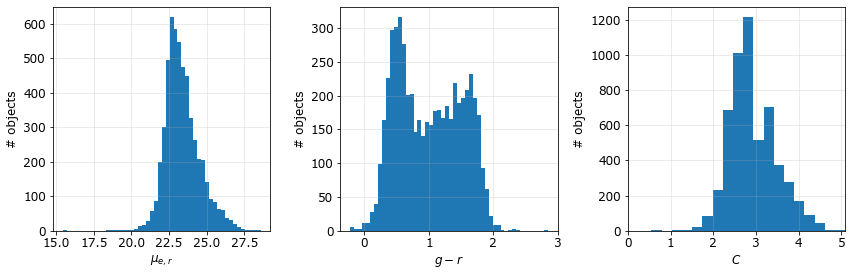

In [7]:
# surface brightness distribution of our objects

fig, fr = plt.subplots(1,3, figsize=(12,4))

fr[0].hist(df_votes['mue_r'], bins=50)
fr[0].update({
    'xlabel': r"$\mu_{e,r}$",
    'ylabel': '# objects'
})

fr[1].hist(df_votes['g']-df_votes['r'], bins=50)
fr[1].update({
    'xlabel': r"$g-r$",
    'ylabel': '# objects',
#     'xlim': fr.get_xlim()[::-1]
})

fr[2].hist(df_votes[df_votes['C'] > 0]['C'], bins=20)
fr[2].update({
    'xlabel': r"$C$",
    'ylabel': '# objects',
    'xlim': [0, df_votes['C'].max()]
})


for i in range(3):
    fr[i].grid(alpha=0.3, which='both')
    
fig.tight_layout()
plt.show()


## Inspect objects without props (these are presumably artifacts)

In [8]:
answers = ['% votes {}'.format(x) for x in ['Galaxy', 'Group of objects (Cluster)', 'Something else/empty center']]

In [9]:
no_props = df_votes[df_votes['RA'].isnull()]

print('# objects without properties: {}'.format(no_props.shape[0]))

# objects without properties: 922


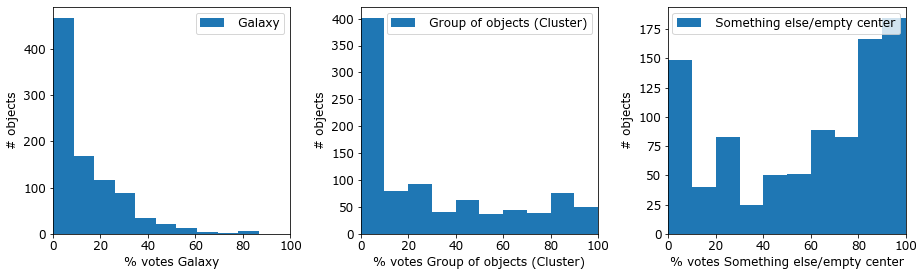

In [10]:
name, gal, group, empty = no_props[['name', *answers]]

fig, fr = plt.subplots(1,3, figsize=(13,4))

for i in range(3):
    fr[i].hist(no_props[answers[i]], label=answers[i][7:])
    fr[i].legend()
    fr[i].update({
        'xlim': [0,100],
        'xlabel': answers[i],
        'ylabel': '# objects'
    })    
    
fig.tight_layout()
plt.show()

In [11]:
# fig, fr = plt.subplots(5,5, figsize=(15,15))
# fr = np.ravel(fr)

# filtered_no_props = no_props[no_props['% votes Galaxy'] > 80]

# for i in range(25):
#     object_name = filtered_no_props.iloc[i]['name']
#     path = '../image/thumbnails/{}_insp.png'.format(object_name)
#     image = Image.open(path)
#     fr[i].imshow(image)
#     fr[i].set_title(object_name)
#     fr[i].set_axis_off()

In [12]:
# add galaxy vote count (as a number, not a percentage) column
df_votes['# votes Galaxy'] = df_votes['counts'].apply(lambda x: x.get('Galaxy', None))

### Percentage of votes A SINGLE OBJECT gets for 'Galaxy' compared to object's surface brightness

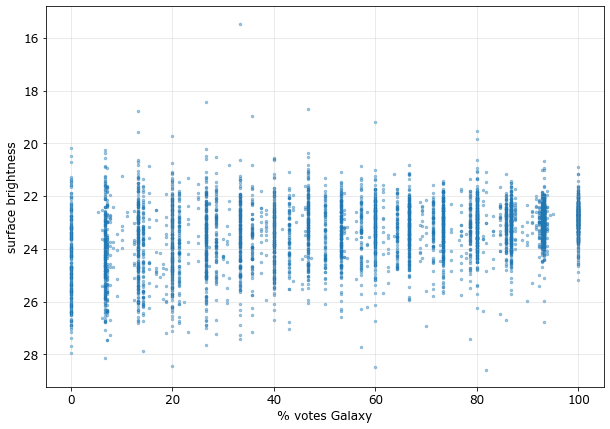

In [13]:
fig, ax = plt.subplots(figsize=(10,7))

ax.scatter(df_votes['% votes Galaxy'], df_votes['mue_r'], s=6, alpha=0.4)
# ax.scatter(df_votes['% votes Group of objects (Cluster)'], df_votes['mue_r'], s=6, alpha=0.4)
# ax.scatter(df_votes['% votes Something else/empty center'], df_votes['mue_r'], s=6, alpha=0.4)
ax.update({
    'xlabel': "% votes Galaxy",
    'ylabel': "surface brightness",
    'ylim': ax.get_ylim()[::-1]
})
ax.grid(alpha=0.3, which='both')

### Difference between %Bright and %Fluffy A SINGLE OBJECT gets (given that the users already voted for 'Galaxy') as a function of surface brightness

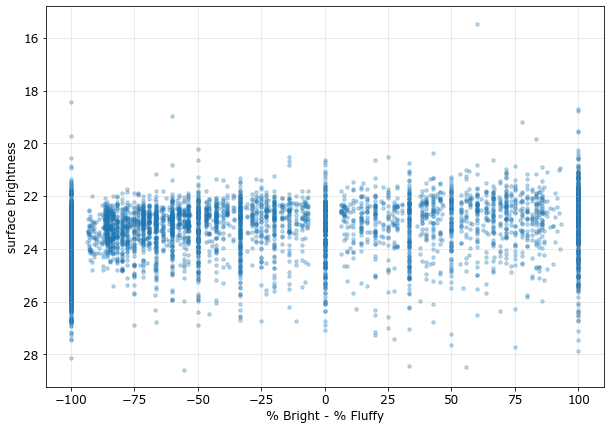

In [14]:
fig, fr = plt.subplots(figsize=(10,7))

# ax.scatter(df_votes['% Fluffy'], df_votes['mue_r'], s=12, alpha=0.3, marker='o')
fr.scatter(df_votes['% Bright']-df_votes['% Fluffy'], df_votes['mue_r'], s=12, alpha=0.3, marker='o')
fr.update({
    'xlabel': "% Bright - % Fluffy",
    'ylabel': "surface brightness",
    'ylim': fr.get_ylim()[::-1]
})
fr.grid(alpha=0.3, which='both')

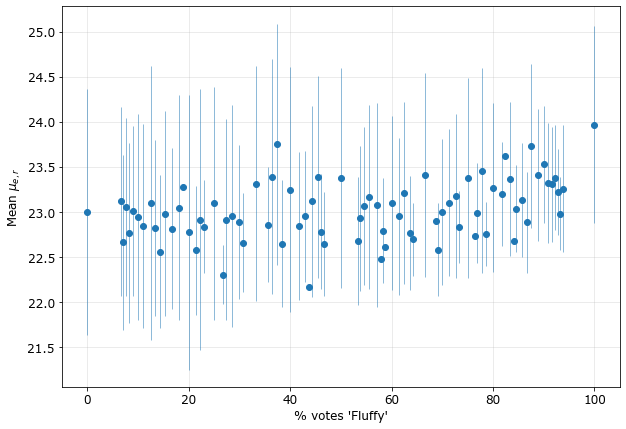

In [15]:
groupby_bright = df_votes.groupby(['% Fluffy'])
sb_mean, sb_std = groupby_bright['mue_r'].agg(['mean', 'std']).T.values

bright = list(groupby_bright.groups.keys())
sb_mean = sb_mean
sb_std = sb_std

fig, fr = plt.subplots(figsize=(10,7))

fr.errorbar(x=bright, y=sb_mean, yerr=sb_std, fmt='o', elinewidth=0.5)

fr.grid(alpha=0.3, which='both')
fr.update({
    'xlabel': "% votes 'Fluffy'",
    'ylabel': r"Mean $\mu_{e,r}$"
})

plt.show()

---
---

Inspect properties of objects in Venhola's catalogue:



In [16]:
df_targets = df[df['Filename'].isin(catalogue_targets)]
df_votes_catalogue = df_votes[df_votes['name'].isin(catalogue_targets)]

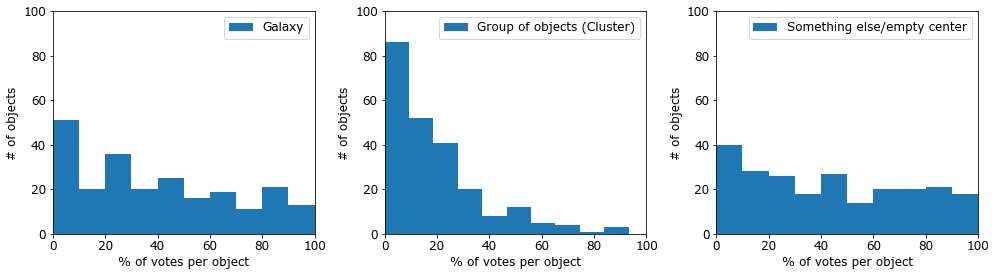

In [17]:
fig, fr = plt.subplots(1,3, figsize=(14,4))

for i, answer in enumerate(answers):
    fr[i].hist(df_votes_catalogue[answer], label=answer_types[i])

    fr[i].update({
        'xlim': [0,100],
        'ylim': [0,100],
        'xlabel': '% of votes per object',
        'ylabel': '# of objects'
    })

    fr[i].legend()

fig.tight_layout()

## Plot some images:

In [18]:
def plot_image_grid(input_df, rows, cols, title=None):
    size = 3*max(rows, cols)
    fig, fr = plt.subplots(rows,cols, figsize=(size, size))
    fr = np.ravel(fr)

    # plot the images of some of these objects to see what the voters saw
    for i, name in enumerate(input_df['name'].head(rows*cols)):
        object_name = name
        path = '../image/thumbnails/{}_insp.png'.format(object_name)
        image = Image.open(path)
        fr[i].imshow(image)
        fr[i].set_title(object_name)
        fr[i].set_axis_off()


    if title:
        fig.suptitle(title)
    fig.tight_layout()
    plt.show()

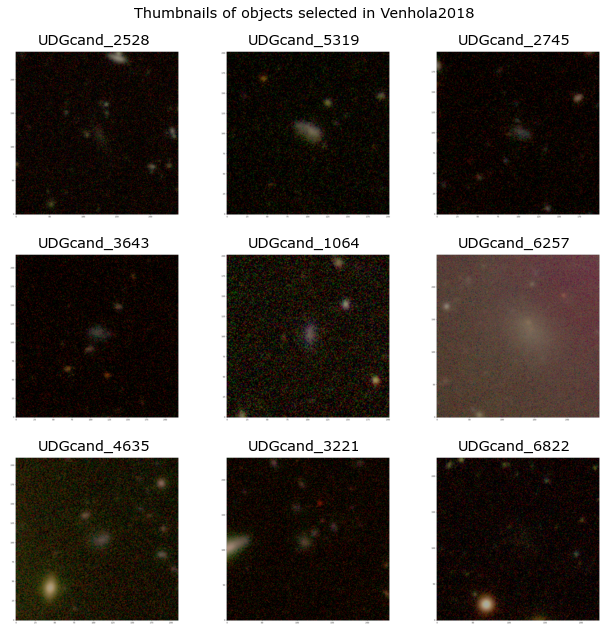

In [19]:
# show images of some catalogue targets
plot_image_grid(df_votes_catalogue, 3, 3, 'Thumbnails of objects selected in Venhola2018')

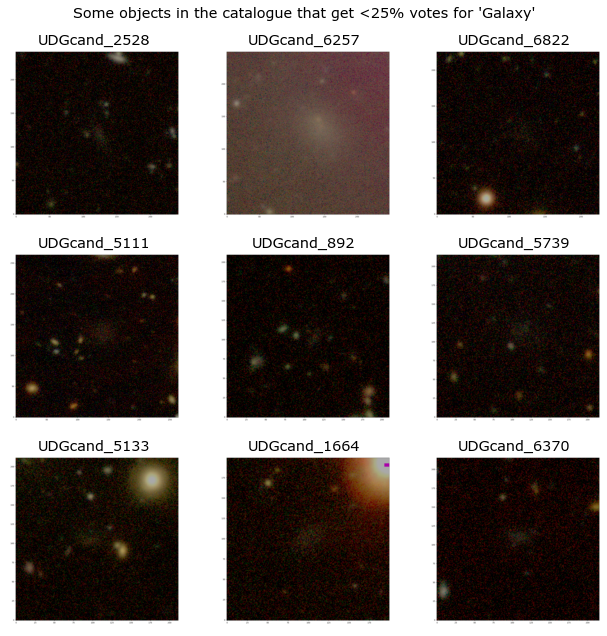

In [29]:
# find some catalogue targets that get few votes for galaxy (< 20%)
few_galaxy = df_votes_catalogue[df_votes_catalogue['% votes Galaxy'] < 25]

plot_image_grid(few_galaxy, 3, 3, "Some objects in the catalogue that get <25% votes for 'Galaxy'")

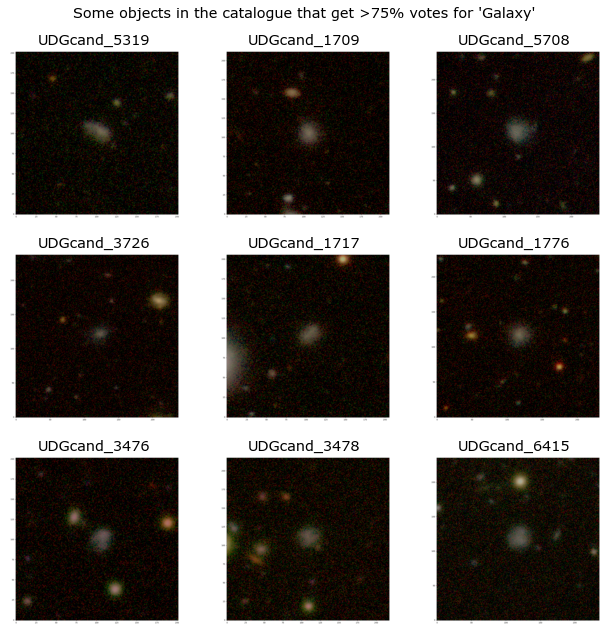

In [30]:
# then, do the same thing but for targets that get many votes for galaxy (> 75%)
many_galaxy = df_votes_catalogue[df_votes_catalogue['% votes Galaxy'] > 75]

plot_image_grid(many_galaxy, 3, 3, "Some objects in the catalogue that get >75% votes for 'Galaxy'")

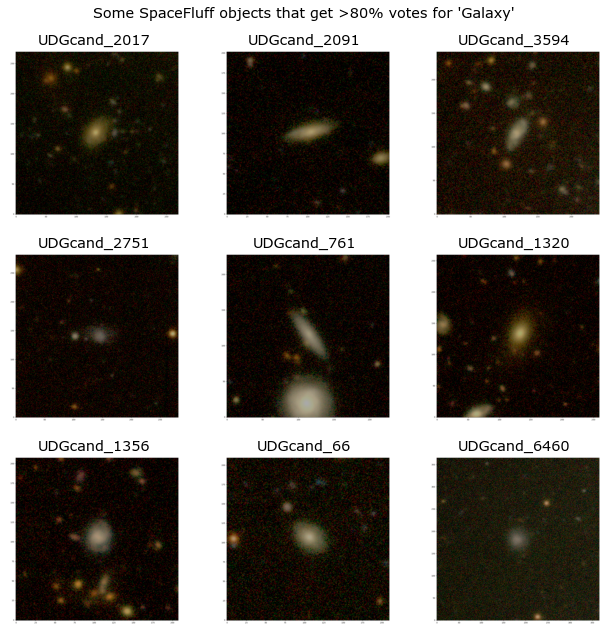

In [28]:
# similarly, plot some objects that get many votes for galaxy (> 80%), but now objects generally, not just ones in the catalogue
many_galaxy = df_votes[df_votes['% votes Galaxy'] > 80]

plot_image_grid(many_galaxy, 3, 3, 'Some SpaceFluff objects that get >80% votes for \'Galaxy\'') 

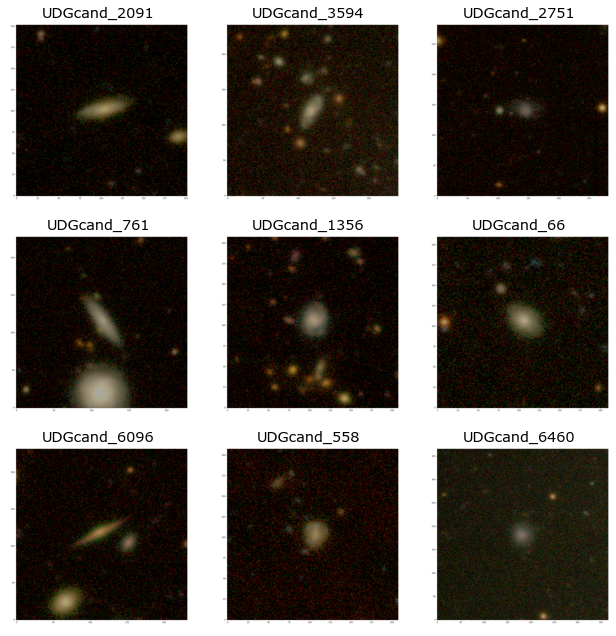

In [23]:
# plot some objects that get many votes for fluffy (> 50%), 
many_fluffy = df_votes[(df_votes['% votes Galaxy'] > 75) & (df_votes['% Fluffy'] > 50)]

plot_image_grid(many_fluffy, 3, 3)

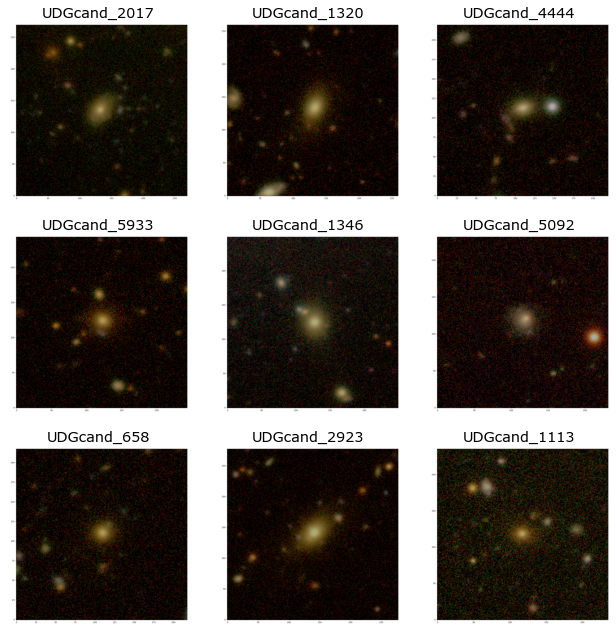

In [24]:
# plot some objects that get many votes for bright (> 50%), 
many_bright = df_votes[(df_votes['% votes Galaxy'] > 75) & (df_votes['% Bright'] > 50)]

plot_image_grid(many_bright, 3, 3)

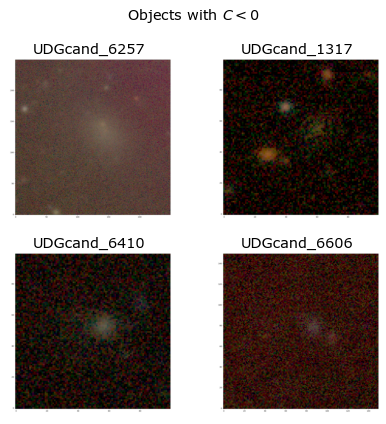

In [25]:
plot_image_grid(df_votes[df_votes['C'] < 0], 2,2, 'Objects with $C<0$')